In [112]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [113]:
def gaussian1DKernel(sigma):
    factor = 5
    h = np.ceil(factor*sigma)
    x = np.arange(-h, h+1)
    g = np.exp(-x**2/(2*sigma**2))
    g /= g.sum()
    g = g.reshape(-1,1)
    gx = (-x/sigma**2) * g
    return (g,gx)

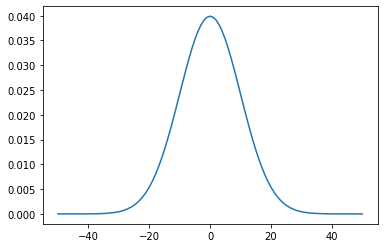

In [114]:
sigma = 10
g, gx = gaussian1DKernel(sigma)
factor = 5
h = np.ceil(factor*sigma)
x = np.arange(-h, h+1)
plt.plot(x,g)

In [115]:
def gaussianSmoothing(image, sigma):
    g,gx = gaussian1DKernel(sigma)
    blured = cv2.filter2D(image, -1, g)
    blured = cv2.filter2D(blured, -1, g.T)
    Ix = cv2.filter2D(image, -1, gx.T)
    Ix = cv2.filter2D(Ix, -1, g)
    Iy = cv2.filter2D(image, -1, gx)
    Iy = cv2.filter2D(Iy, -1, g.T)
    return (blured,Ix,Iy)

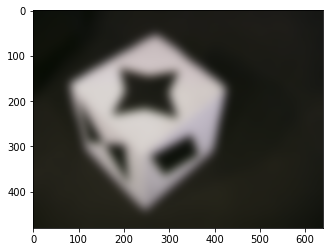

In [116]:
im = cv2.imread("data/Box3.bmp")[:,:,::-1]
I, Ix, Iy = gaussianSmoothing(im, sigma)
plt.imshow(I)

In [117]:
def smoothedHessian(im, sigma, epsilon: int):
    if epsilon < 1:
        epsilon = 1
    g,_ = gaussian1DKernel(sigma)
    ge = np.repeat(g,epsilon,axis=1)
    _, Ix, Iy = gaussianSmoothing(im, sigma)
    return np.array([
        [cv2.filter2D(Ix**2, -1, ge), cv2.filter2D(Ix*Iy, -1, ge)],
        [cv2.filter2D(Ix*Iy, -1, ge), cv2.filter2D(Iy**2, -1, ge)],
    ])

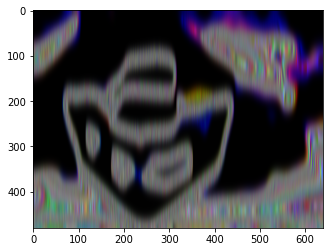

In [118]:
epsilon = 1
im = cv2.imread("data/Box3.bmp")[:,:,::-1]
C = smoothedHessian(im, sigma, epsilon)
plt.imshow(C[0,0,:])

In [119]:
def harrisMeasure(im, sigma, epsilon, k):
    C = smoothedHessian(im, sigma, epsilon)
    r = (C[0,0,:] * C[1,1,:] - C[0,1,:]**2 - k * (C[0,0,:] + C[1,1,:])).sum(axis=2)
    r /= r.max()
    return r

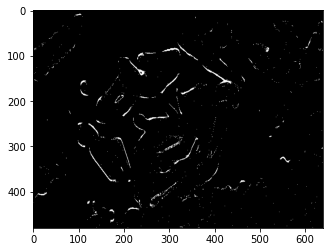

In [120]:
k = .06
epsilon = 1
sigma = 5
im = cv2.imread("data/Box3.bmp")[:,:,::-1]
r = harrisMeasure(im, sigma, epsilon, k)
r[r < .9] = 0
plt.imshow(r,cmap='gray')

In [121]:
from scipy import ndimage
### Non-maximum supression
image = cv2.imread("data/Box3.bmp")[:,:,::-1].astype(np.float64)
image /= image.max()

# Use the max filter to make a mask
roi = 3
size = 2 * roi + 1
image_max = ndimage.maximum_filter(image, size=size, mode='constant')
mask = (image == image_max)
image *= mask

# Remove the image borders
image[:roi] = 0
image[-roi:] = 0
image[:, :roi] = 0
image[:, -roi:] = 0

# Optionally find peaks above some threshold
image_t = (image > .99) * 1

# # get coordinates of peaks
f = np.transpose(image_t.nonzero())
f.shape

(63, 3)

(<matplotlib.image.AxesImage at 0x281f47b2b50>, 1)

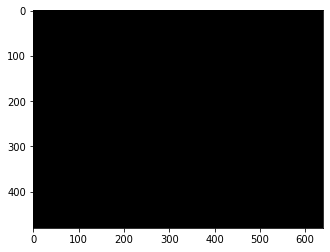

In [122]:
plt.imshow(image_t), image_t.max()

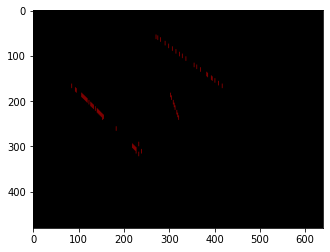

In [123]:
dilated = cv2.dilate((image_t*255).astype(np.uint8), np.ones(10,dtype=np.uint8))
plt.imshow(dilated)